# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [203]:
from statsmodels.stats import outliers_influence
from sklearn import preprocessing
import matplotlib.pyplot as plt
from statsmodels import tools
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import re

#### Loading Data

In [93]:
housing_data_url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
houses = pd.read_csv(housing_data_url)

#### Replace `NaN`'s in Categorical Columns

In [94]:
houses['Alley'] = houses['Alley'].fillna('Nothing')
houses['Fence'] = houses['Fence'].fillna('No Fence')
houses['PoolQC'] = houses['PoolQC'].fillna('No Pool')
houses['GarageYrBlt'] = houses['GarageYrBlt'].fillna(0)
houses['MiscFeature'] = houses['MiscFeature'].fillna('None')
houses['MasVnrType'] = houses['MasVnrType'].fillna('Unknown')
houses['Electrical'] = houses['Electrical'].fillna('Unknown')
houses['FireplaceQu'] = houses['FireplaceQu'].fillna('No Fireplace')

houses = houses.assign(
    **houses[[col for col in houses.columns.values if 'Bsmt' in col]]\
        .fillna('No Basement')\
        .to_dict(orient='series')
)

houses = houses.assign(
    **houses[[col for col in houses.drop(columns='GarageYrBlt').columns.values if 'Garage' in col]]\
        .fillna('No Garage')\
        .to_dict(orient='series')
)

#### Convert Columns To Snake Case

In [95]:
def snakecase(word):
    return re.sub(r"(?<!^)([A-Z][a-z0-9]+)", r"_\1", word).lower()

In [96]:
print(snakecase('VSCode'), snakecase('SQL'), snakecase('PaulGraham'))

vs_code sql paul_graham


In [97]:
cols = houses.columns.values
snake_case = [snakecase(col) for col in cols]
houses = houses.rename(columns={old: new for old, new in zip(cols, snake_case)})

In [154]:
numeric_houses = houses.select_dtypes(np.number)

In [207]:
numeric_houses.head(1)

,id,ms_sub_class,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmt_fins_f1,...,wood_decksf,open_porchsf,enclosed_porch,3_ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_price
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500


## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

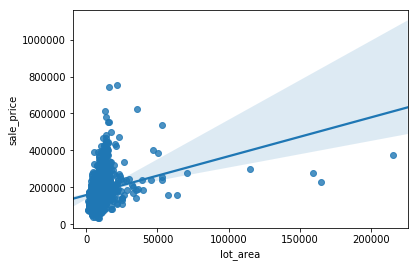

In [155]:
sns.regplot(
    x='lot_area',
    y='sale_price',
    data=numeric_houses
)

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [208]:
X = numeric_houses[['lot_area', 'fireplaces', 'full_bath']]
y = numeric_houses.sale_price

model = sm.OLS(y, X).fit()

In [209]:
tools.eval_measures.rmse(y, model.predict(X))

60745.006931996155

In [210]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [211]:
tools.eval_measures.rmse(y, model.predict(X))

59262.205638621221

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [212]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     386.2
Date:                Fri, 22 Feb 2019   Prob (F-statistic):          1.63e-184
Time:                        19:07:08   Log-Likelihood:                -18117.
No. Observations:                1460   AIC:                         3.624e+04
Df Residuals:                    1456   BIC:                         3.626e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.128e+04   4806.284      8.589      0.000    3.19e+04    5.07e+04
lot_area       0.9376      0.162      5.785      0.000       0.620       1.255
fireplaces  3.956e+04   2566.444     15.414      0.000    3.45e+04    4.46e+04
full_bath   6.743e+04   2913.726     23.141      0.000    6.17e+04    7.31e+04
==============================================================================
Omnibus:                      543.105   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3282.947
Skew:                           1.611   Prob(JB):                         0.00
Kurtosis:                       9.602   Cond. No.                     5.10e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Each p-value gives the probability that the null-hypothesis is correct, specifically, that the coefficient has no effect on the predicted value. For example the `const` feature with coefficient `4.717e+04` has a pvalue much less than 0.05 indicating that their is high probability that said feature impacts the predicted value. This is as opposed to a feature like alley, for which there is little probability that the null-hypothesis is false. 

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [213]:
numric_houses_wo_outliers = numeric_houses[(np.nan_to_num(np.abs(stats.zscore(numeric_houses))) < 3).all(axis=1)].copy(deep=True)

In [214]:
X = numric_houses_wo_outliers[['fireplaces', 'full_bath']]
y = numric_houses_wo_outliers.sale_price

model = sm.OLS(y, X).fit()

In [215]:
tools.eval_measures.rmse(y, model.predict(X))

48207.912756572347

In [216]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     7117.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:07:14   Log-Likelihood:                -12080.
No. Observations:                 990   AIC:                         2.416e+04
Df Residuals:                     988   BIC:                         2.417e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
fireplaces  2.988e+04   2699.018     11.071      0.000    2.46e+04    3.52e+04
full_bath   9.885e+04   1337.374     73.915      0.000    9.62e+04    1.01e+05
==============================================================================
Omnibus:                       30.588   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.257
Skew:                           0.209   Prob(JB):                     6.08e-13
Kurtosis:                       4.090   Cond. No.                         3.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TODO: Response

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [244]:
numric_houses_wo_outliers['log_sale_price'] = np.log(numric_houses_wo_outliers['sale_price'])

In [245]:
X = numric_houses_wo_outliers[['lot_area', 'fireplaces', 'full_bath']]
y = numric_houses_wo_outliers.log_sale_price

model = sm.OLS(y, X).fit()

In [246]:
tools.eval_measures.rmse(y, model.predict(X))

2.9547704350392081

In [247]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_sale_price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     5128.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:22:31   Log-Likelihood:                -2477.3
No. Observations:                 990   AIC:                             4961.
Df Residuals:                     987   BIC:                             4975.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lot_area       0.0004   2.22e-05     20.016      0.000       0.000       0.000
fireplaces    -0.4056      0.169     -2.394      0.017      -0.738      -0.073
full_bath      4.6409      0.136     34.167      0.000       4.374       4.907
==============================================================================
Omnibus:                       13.104   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.879
Skew:                          -0.217   Prob(JB):                      0.00263
Kurtosis:                       2.683   Cond. No.                     1.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [224]:
vif_rule_of_thumb = 10

In [225]:
vif = np.array([outliers_influence.variance_inflation_factor(X.values, i) for i in range(X.shape[1])])

In [226]:
vif > vif_rule_of_thumb

array([False, False, False], dtype=bool)

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [227]:
X.cov()

,lot_area,fireplaces,full_bath
lot_area,1.428112e+07,611.856059,353.868432
fireplaces,6.118561e+02,0.352283,0.088233
full_bath,3.538684e+02,0.088233,0.265961


## 2.3 If you have varaibles with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [ ]:
# TODO: None of my variables have 

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [228]:
model = sm.OLS(y, X).fit(cov_type='HC3')

In [229]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_sale_price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     6922.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:08:49   Log-Likelihood:                -2477.3
No. Observations:                 990   AIC:                             4961.
Df Residuals:                     987   BIC:                             4975.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lot_area       0.0004   2.85e-05     15.608      0.000       0.000       0.000
fireplaces    -0.4056      0.174     -2.330      0.020      -0.747      -0.064
full_bath      4.6409      0.146     31.742      0.000       4.354       4.927
==============================================================================
Omnibus:                       13.104   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.879
Skew:                          -0.217   Prob(JB):                      0.00263
Kurtosis:                       2.683   Cond. No.                     1.90e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

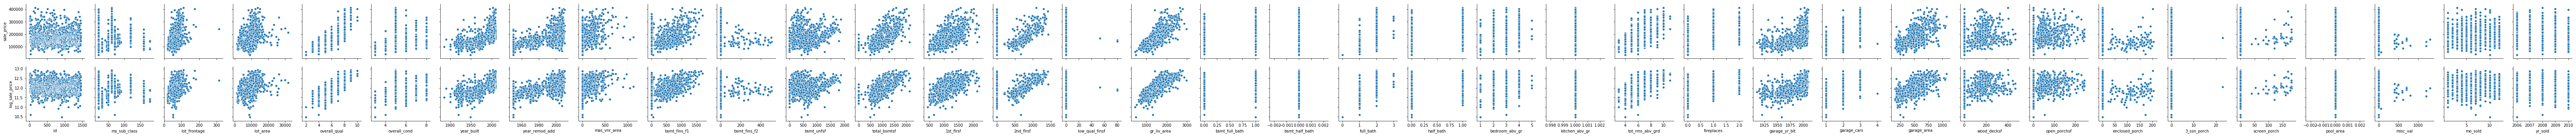

In [231]:
sns.pairplot(data=numric_houses_wo_outliers, y_vars=['sale_price', 'log_sale_price'], x_vars=numric_houses_wo_outliers.drop(columns=['log_sale_price', 'sale_price']).columns)

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


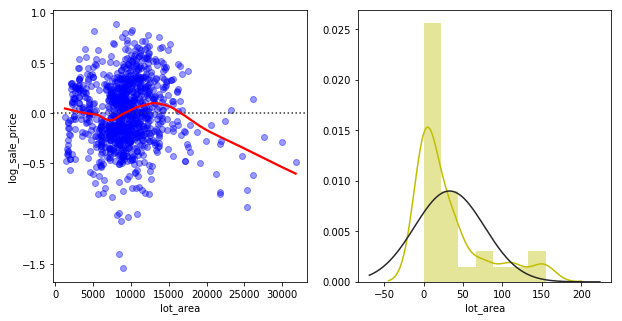

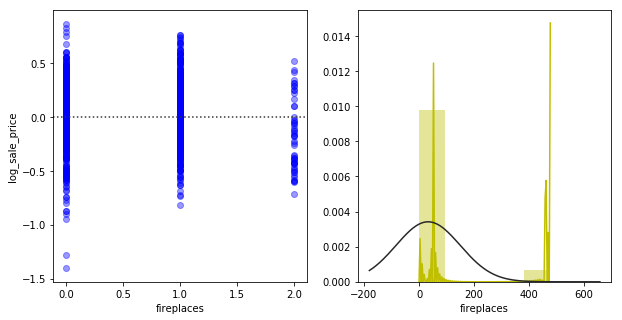

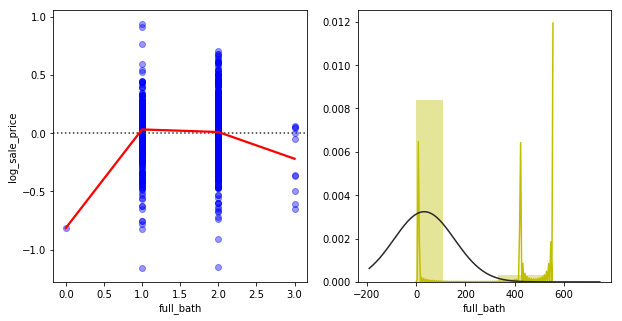

In [249]:
for col in X.columns:
    _, axes = plt.subplots(1,2, figsize=(10,5))
    sns.residplot(x=X[col], y=y, lowess=True, color="r", ax=axes[0], scatter_kws={'color':'blue', 'alpha': 0.4})
    cuts = pd.cut(X[col], 30).value_counts()
    sns.distplot(cuts, ax=axes[1], color='y', fit=stats.norm)

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [251]:
X = X.copy(deep=True)

In [252]:
X['poly_lot_area'] = X['lot_area']**2

In [253]:
model = sm.OLS(y, X).fit(cov_type='HC3')

In [254]:
model.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_sale_price   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     799.9
Date:                Fri, 22 Feb 2019   Prob (F-statistic):          1.55e-263
Time:                        19:24:24   Log-Likelihood:                -2193.4
No. Observations:                 990   AIC:                             4395.
Df Residuals:                     986   BIC:                             4414.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
lot_area          0.0013   7.98e-05     16.195      0.000       0.001       0.001
fireplaces       -0.2447      0.129     -1.896      0.058      -0.498       0.008
full_bath         2.7185      0.158     17.217      0.000       2.409       3.028
poly_lot_area -4.568e-08   5.64e-09     -8.098      0.000   -5.67e-08   -3.46e-08
==============================================================================
Omnibus:                      176.246   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.163
Skew:                           1.003   Prob(JB):                     2.08e-82
Kurtosis:                       5.257   Cond. No.                     2.69e+08
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 2.69e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

TODO: Response